# Choose Cluster

In [1]:
cluster_input = 10
cluster = str(cluster_input)
clust_to_celltype = {1: 'excitatory_neurons', 2: 'inhibitory_neurons', 3: 'excitatory_neurons',
                     4: 'excitatory_neurons', 5: 'nigral_neurons', 6: 'nigral_neurons', 7: 'unknown_neurons',
                     8: 'opcs', 9: 'opcs', 10: 'opcs', 11: 'inhibitory_neurons',12: 'inhibitory_neurons',
                     13: 'astrocytes', 14: 'astrocytes', 15: 'astrocytes', 16: 'astrocytes', 17: 'astrocytes',
                     18: 'doublets', 19: 'oligodendrocytes', 20: 'oligodendrocytes', 21: 'oligodendrocytes',
                     22: 'oligodendrocytes', 23: 'oligodendrocytes', 24: 'microglia'}

celltype = clust_to_celltype[cluster_input]

# Quick Links

<ol>
    <li><a href=#prep_sig_scores>Prepare Significance Scores</a></li>
    <li><a href=#prep_conf_scores>Prepare Confidence Scores</a></li>
    <li><a href=#prep_score_df>Prepare Score DataFrames</a></li>
    <li><a href=#plot_score_distrib>Plot Score Distributions</a></li>
    <li><a href=#calculate_pvals>Calculate P-Values</a></li>
    <li><a href=#visualize_high_conf>Visualize High Confidence SNPs</a></li>
    <li><a href=#prep_final_table>Prepare Final SNPs Table</a></li>
</ol>

## Imports

In [2]:
# Basic

import sys
import math
import random
import statistics
from decimal import Decimal

# Data / ML / Stats Libraries

import numpy as np
import pandas as pd
import scipy
from scipy.stats import *
pd.set_option('display.max_columns', None)

# Visualization

import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from plotnine import *
sys.path.insert(0, '/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm')
from viz_preprocess import *
from viz_sequence import *
plt.style.use('default')

## Addresses

In [3]:
real_base = '/mnt/lab_data3/soumyak/adpd/'
real_effect_fasta = real_base + 'fasta_inputs/Cluster' + cluster + '.effect.fasta'
real_noneffect_fasta = real_base + 'fasta_inputs/Cluster' + cluster + '.noneffect.fasta'
null_base = '/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'

## Get Input Sequences

In [4]:
real_effect_seqs = [x.rstrip() for (i,x) in enumerate(open(real_effect_fasta)) if i%2==1]
real_effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in real_effect_seqs]

print('Num Real effect sequences:', '\t', '\t', len(real_effect_onehot))

real_noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(real_noneffect_fasta)) if i%2==1]
real_noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in real_noneffect_seqs]

print('Num Real noneffect sequences:', '\t', '\t', len(real_noneffect_onehot))

Num Real effect sequences: 	 	 230
Num Real noneffect sequences: 	 	 230


# Prepare Real Scores <a name='prep_sig_scores' />

In [5]:
merged_real_effect_scores = np.zeros(shape=(len(real_effect_seqs), 1000, 4))
merged_real_noneffect_scores = np.zeros(shape=(len(real_noneffect_seqs), 1000, 4))
merged_real_explain_scores = np.zeros(shape=(len(real_effect_seqs),))

for fold in range(10):
    real_effect_file = real_base + 'explain_scores/Cluster' + cluster + '/fold' + str(fold) + '.effect.scores.txt'
    real_effect_scores = get_hyp_scores(real_effect_file, real_effect_seqs)
    real_effect_scores = np.array(real_effect_scores)
    merged_real_effect_scores = merged_real_effect_scores + real_effect_scores
    
    real_noneffect_file = real_base + 'explain_scores/Cluster' + cluster + '/fold' + str(fold) + '.noneffect.scores.txt'
    real_noneffect_scores = get_hyp_scores(real_noneffect_file, real_noneffect_seqs)
    real_noneffect_scores = np.array(real_noneffect_scores)
    merged_real_noneffect_scores = merged_real_noneffect_scores + real_noneffect_scores
       
    real_explain_scores = []
    
    for i,j in enumerate(real_effect_scores): # iterate over sequences
        real_50bp_imp_effect = np.sum(np.array([np.sum(j) \
                                for j in \
                                real_effect_scores[i][475:525]]))
        real_50bp_imp_noneffect = np.sum(np.array([np.sum(j) \
                                    for j in \
                                    real_noneffect_scores[i][475:525]]))
        real_explain_score_seq = real_50bp_imp_effect - real_50bp_imp_noneffect
        real_explain_scores.append(real_explain_score_seq)
    
    merged_real_explain_scores = merged_real_explain_scores + np.array(real_explain_scores)
    
merged_real_effect_scores = merged_real_effect_scores / (fold + 1)
merged_real_noneffect_scores = merged_real_noneffect_scores / (fold + 1)
merged_real_explain_scores = merged_real_explain_scores / (fold + 1)

print('Num Real GkmExplain scores:', '\t', '\t', len(merged_real_explain_scores))
print('Num Real Effect scores:', '\t', '\t', len(merged_real_effect_scores))
print('Num Real Non-Effect scores:', '\t', '\t', len(merged_real_noneffect_scores))

#--------------------------------------------------------#

merged_real_ism_scores = np.zeros(shape=(len(real_effect_seqs),))
merged_real_delta_scores = np.zeros(shape=(len(real_effect_seqs),))

for fold in range(10):
    real_ism_scores = np.array([float(i.strip().split('\t')[1]) \
                                    for i in open(real_base + 'ism_scores/Cluster'
                                    + cluster + '/fold' + str(fold) + '.ism.scores').readlines()])
    real_delta_scores = np.array([float(i.strip().split('\t')[1]) \
                                    for i in open(real_base + 'delta_scores/Cluster'
                                    + cluster + '/fold' + str(fold) + '.delta.scores').readlines()])
    merged_real_ism_scores = merged_real_ism_scores + real_ism_scores
    merged_real_delta_scores = merged_real_delta_scores + real_delta_scores
        
merged_real_ism_scores = merged_real_ism_scores / (fold + 1)
merged_real_delta_scores = merged_real_delta_scores / (fold + 1)

print('Num Real ISM scores:', '\t', '\t', '\t', len(merged_real_ism_scores))
print('Num Real deltaSVM scores:', '\t', '\t', len(merged_real_delta_scores))

Num Real GkmExplain scores: 	 	 230
Num Real Effect scores: 	 	 230
Num Real Non-Effect scores: 	 	 230
Num Real ISM scores: 	 	 	 230
Num Real deltaSVM scores: 	 	 230


# Prepare Null Scores

In [6]:
null_importance_scores = []
merged_null_effect_scores = []
merged_null_noneffect_scores = []
merged_null_explain_scores = []

for fold in range(10):
    for shuf in range(10):
        null_effect_file = null_base + 'shuffled_explain_scores/Cluster' \
                            + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.effect.scores'
        null_effect_scores = get_scores(null_effect_file)
                
        null_noneffect_file = null_base + 'shuffled_explain_scores/Cluster' \
                                + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.noneffect.scores'
        null_noneffect_scores = get_scores(null_noneffect_file)
        
        for i,j in enumerate(null_effect_scores):
            merged_null_effect_scores.append([sum(k) for k in null_effect_scores[i]])
            merged_null_noneffect_scores.append([sum(k) for k in null_noneffect_scores[i]])
            
for i,j in enumerate(merged_null_effect_scores):
    null_effect_50bp = sum(merged_null_effect_scores[i][75:125])
    null_noneffect_50bp = sum(merged_null_noneffect_scores[i][75:125])
    null_explain_score = null_effect_50bp - null_noneffect_50bp
    merged_null_explain_scores.append(null_explain_score)
    
    for k,l in enumerate(merged_null_effect_scores[i]):
        null_importance_scores.append(l)
        assert l == merged_null_effect_scores[i][k]                
            
print('Num Null importance scores:', '\t', len(null_importance_scores))
print('Num Null GkmExplain scores:', '\t', len(merged_null_explain_scores))
    
#--------------------------------------------------------#

merged_null_ism_scores = []
merged_null_delta_scores = []

for fold in range(10):
    for shuf in range(10):
        null_ism_scores = np.array([float(i.strip().split('\t')[1]) \
                            for i in open(null_base + 'shuffled_ism_scores/Cluster'
                            + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.ism.scores').readlines()])
        null_delta_scores = np.array([float(i.strip().split('\t')[1]) \
                                for i in open(null_base + 'shuffled_delta_scores/Cluster'
                                + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.delta.scores').readlines()])
        for null_i_score in null_ism_scores:
            merged_null_ism_scores.append(null_i_score)
        for null_d_score in null_delta_scores:
            merged_null_delta_scores.append(null_d_score)

print('Num Null ISM scores:', '\t', '\t', len(merged_null_ism_scores))
print('Num Null deltaSVM scores:', '\t', len(merged_null_delta_scores))

Num Null importance scores: 	 4380000
Num Null GkmExplain scores: 	 21900
Num Null ISM scores: 	 	 21900
Num Null deltaSVM scores: 	 21900


# Get Real Confidence Scores <a name='prep_conf_scores' />

In [7]:
real_confidence_dict = {'real_center_start': [], 'real_center_end': [],
                        'real_center_effect': [], 'real_center_noneffect': [],
                        'real_bg_effect': [], 'real_bg_noneffect': [],
                        'real_magnitude_score': [], 'real_prominence_score': [],
                        'real_active_allele': [], 'real_inactive_allele': [],
                        'real_center_len': []}

null_upper_thresh = np.quantile(null_importance_scores, 0.95)
print('Per-base Importance Score Threshold: ', '\t', null_upper_thresh)

for seq in range(len(real_effect_seqs)):
    real_per_seq_dict = {'real_scores_active': [], 'real_scores_inactive': [],
                         'real_scores_effect': [], 'real_scores_noneffect': [],
                         'real_active_allele': ''}
    real_center_start = 0
    real_center_end = 0
    real_center_effect = 0
    real_center_noneffect = 0
    real_bg_effect = 0
    real_bg_noneffect = 0
    
    real_effect_total = np.sum(np.array([np.sum(i) for i in merged_real_effect_scores[seq][475:525]]))
    real_noneffect_total = np.sum(np.array([np.sum(i) for i in merged_real_noneffect_scores[seq][475:525]]))
    real_per_seq_dict['real_scores_effect'] = [np.sum(j) for j in merged_real_effect_scores[seq]]
    real_per_seq_dict['real_scores_noneffect'] = [np.sum(j) for j in merged_real_noneffect_scores[seq]]
    if real_effect_total >= real_noneffect_total:
        real_per_seq_dict['real_active_allele'] = 'effect'
        real_per_seq_dict['real_inactive_allele'] = 'noneffect'
        real_confidence_dict['real_active_allele'].append('effect')
        real_confidence_dict['real_inactive_allele'].append('noneffect')
    else:
        real_per_seq_dict['real_active_allele'] = 'noneffect'
        real_per_seq_dict['real_inactive_allele'] = 'effect'
        real_confidence_dict['real_active_allele'].append('noneffect')
        real_confidence_dict['real_inactive_allele'].append('effect')
    real_per_seq_dict['real_scores_active'] = real_per_seq_dict['real_scores_'+real_per_seq_dict['real_active_allele']]
    real_per_seq_dict['real_scores_inactive'] = real_per_seq_dict['real_scores_'+real_per_seq_dict['real_inactive_allele']]
    
    start = 499
    end = 499
    while True:
        if real_per_seq_dict['real_scores_active'][start - 1] <= null_upper_thresh:
            if real_per_seq_dict['real_scores_active'][start - 2] <= null_upper_thresh:
                break
            else:
                start -= 1
        else:
            start -= 1
    while True:
        if real_per_seq_dict['real_scores_active'][end] <= null_upper_thresh:
            if real_per_seq_dict['real_scores_active'][end + 1] <= null_upper_thresh:
                break
            else:
                end += 1
        else:
            end += 1
    if start != end:
        real_motif_len = end - start
        if (real_motif_len) < 7:
            real_center_start = start - math.floor((10 - real_motif_len) / 2)
            real_center_end = end + math.ceil((10 - real_motif_len) / 2)
        else:
            real_center_start = start
            real_center_end = end
    else:
        real_center_start = start - 4
        real_center_end = end + 6
    
    real_confidence_dict['real_center_start'].append(real_center_start)
    real_confidence_dict['real_center_end'].append(real_center_end)
    real_confidence_dict['real_center_len'].append(real_center_end - real_center_start)
    
    for i,j in enumerate(real_per_seq_dict['real_scores_active'][real_center_start:real_center_end]):
        if real_per_seq_dict['real_scores_effect'][i+real_center_start] >= 0:
            real_center_effect += real_per_seq_dict['real_scores_effect'][i+real_center_start]
        if real_per_seq_dict['real_scores_noneffect'][i+real_center_start] >= 0:
            real_center_noneffect += real_per_seq_dict['real_scores_noneffect'][i+real_center_start]
        assert j == real_per_seq_dict['real_scores_active'][i+real_center_start]
    for i,j in enumerate(real_per_seq_dict['real_scores_active']):
        if real_per_seq_dict['real_scores_effect'][i] >= 0:
            real_bg_effect += real_per_seq_dict['real_scores_effect'][i]
        if real_per_seq_dict['real_scores_noneffect'][i] >= 0:
            real_bg_noneffect += real_per_seq_dict['real_scores_noneffect'][i]
        assert j == real_per_seq_dict['real_scores_active'][i]
    
    real_magnitude_score = real_center_effect - real_center_noneffect
    real_prominence_score = (real_center_effect / real_bg_effect) - (real_center_noneffect / real_bg_noneffect)
    
    real_confidence_dict['real_center_effect'].append(real_center_effect)
    real_confidence_dict['real_center_noneffect'].append(real_center_noneffect)
    real_confidence_dict['real_bg_effect'].append(real_bg_effect)
    real_confidence_dict['real_bg_noneffect'].append(real_bg_noneffect)
    real_confidence_dict['real_magnitude_score'].append(real_magnitude_score)
    real_confidence_dict['real_prominence_score'].append(real_prominence_score)

print('Mean Real motif length:', '\t', '\t', statistics.mean(real_confidence_dict['real_center_len']))
print('Median Real motif length:', '\t', '\t', statistics.median(real_confidence_dict['real_center_len']))
print('St. Dev Real motif length:', '\t', '\t', statistics.stdev(real_confidence_dict['real_center_len']))
print('Mode Real motif length:', '\t', '\t', statistics.mode(real_confidence_dict['real_center_len']))
print('Max Real motif length:', '\t', '\t', '\t', max(real_confidence_dict['real_center_len']))
print('Min Real motif lenght:', '\t', '\t', '\t', min(real_confidence_dict['real_center_len']))

Per-base Importance Score Threshold:  	 0.0210341
Mean Real motif length: 	 	 11.582608695652175
Median Real motif length: 	 	 10.0
St. Dev Real motif length: 	 	 4.806259762328793
Mode Real motif length: 	 	 10
Max Real motif length: 	 	 	 41
Min Real motif lenght: 	 	 	 7


# Get Null Confidence Scores

In [8]:
null_confidence_dict = {'null_center_start': [], 'null_center_end': [],
                        'null_center_effect': [], 'null_center_noneffect': [],
                        'null_bg_effect': [], 'null_bg_noneffect': [],
                        'null_magnitude_score': [], 'null_prominence_score': [],
                        'null_active_allele': [], 'null_inactive_allele': [],
                        'null_center_len': []}

null_upper_thresh = np.quantile(null_importance_scores, 0.95)
print('Per-base Importance Score Threshold: ', '\t', null_upper_thresh)

for seq in range(len(merged_null_effect_scores)):
    null_per_seq_dict = {'null_scores_active': [], 'null_scores_inactive': [],
                         'null_scores_effect': [], 'null_scores_noneffect': [],
                         'null_active_allele': ''}
    null_center_start = 0
    null_center_end = 0
    null_center_effect = 0
    null_center_noneffect = 0
    null_bg_effect = 0
    null_bg_noneffect = 0
    
    null_effect_total = sum(merged_null_effect_scores[seq][75:125])
    null_noneffect_total = sum(merged_null_noneffect_scores[seq][75:125])
    null_per_seq_dict['null_scores_effect'] = merged_null_effect_scores[seq]
    null_per_seq_dict['null_scores_noneffect'] = merged_null_noneffect_scores[seq]
    if null_effect_total >= null_noneffect_total:
        null_per_seq_dict['null_active_allele'] = 'effect'
        null_per_seq_dict['null_inactive_allele'] = 'noneffect'
        null_confidence_dict['null_active_allele'].append('effect')
        null_confidence_dict['null_inactive_allele'].append('noneffect')
    else:
        null_per_seq_dict['null_active_allele'] = 'noneffect'
        null_per_seq_dict['null_inactive_allele'] = 'effect'
        null_confidence_dict['null_active_allele'].append('noneffect')
        null_confidence_dict['null_inactive_allele'].append('effect')
    null_per_seq_dict['null_scores_active'] = null_per_seq_dict['null_scores_'+null_per_seq_dict['null_active_allele']]
    null_per_seq_dict['null_scores_inactive'] = null_per_seq_dict['null_scores_'+null_per_seq_dict['null_inactive_allele']]
    
    start = 99
    end = 99
    while True:
        if null_per_seq_dict['null_scores_active'][start - 1] <= null_upper_thresh:
            if null_per_seq_dict['null_scores_active'][start - 2] <= null_upper_thresh:
                break
            else:
                start -= 1
        else:
            start -= 1
    while True:
        if null_per_seq_dict['null_scores_active'][end] <= null_upper_thresh:
            if null_per_seq_dict['null_scores_active'][end + 1] <= null_upper_thresh:
                break
            else:
                end += 1
        else:
            end += 1
    if start != end:
        null_motif_len = end - start
        if (null_motif_len) < 7:
            null_center_start = start - math.floor((10 - null_motif_len) / 2)
            null_center_end = end + math.ceil((10 - null_motif_len) / 2)
        else:
            null_center_start = start
            null_center_end = end
    else:
        null_center_start = start - 4
        null_center_end = end + 6
    
    null_confidence_dict['null_center_start'].append(null_center_start)
    null_confidence_dict['null_center_end'].append(null_center_end)
    null_confidence_dict['null_center_len'].append(null_center_end - null_center_start)
    
    for i,j in enumerate(null_per_seq_dict['null_scores_active'][null_center_start:null_center_end]):
        if null_per_seq_dict['null_scores_effect'][i+null_center_start] >= 0:
            null_center_effect += null_per_seq_dict['null_scores_effect'][i+null_center_start]
        if null_per_seq_dict['null_scores_noneffect'][i+null_center_start] >= 0:
            null_center_noneffect += null_per_seq_dict['null_scores_noneffect'][i+null_center_start]
        assert j == null_per_seq_dict['null_scores_active'][i+null_center_start]
    for i,j in enumerate(null_per_seq_dict['null_scores_active']):
        if null_per_seq_dict['null_scores_effect'][i] >= 0:
            null_bg_effect += null_per_seq_dict['null_scores_effect'][i]
        if null_per_seq_dict['null_scores_noneffect'][i] >= 0:
            null_bg_noneffect += null_per_seq_dict['null_scores_noneffect'][i]
        assert j == null_per_seq_dict['null_scores_active'][i]
    
    null_magnitude_score = null_center_effect - null_center_noneffect
    null_prominence_score = (null_center_effect / null_bg_effect) - (null_center_noneffect / null_bg_noneffect)
    
    null_confidence_dict['null_center_effect'].append(null_center_effect)
    null_confidence_dict['null_center_noneffect'].append(null_center_noneffect)
    null_confidence_dict['null_bg_effect'].append(null_bg_effect)
    null_confidence_dict['null_bg_noneffect'].append(null_bg_noneffect)
    null_confidence_dict['null_magnitude_score'].append(null_magnitude_score)
    null_confidence_dict['null_prominence_score'].append(null_prominence_score)

print('Mean Null motif length:', '\t', '\t', statistics.mean(null_confidence_dict['null_center_len']))
print('Median Null motif length:', '\t', '\t', statistics.median(null_confidence_dict['null_center_len']))
print('St. Dev Null motif length:', '\t', '\t', statistics.stdev(null_confidence_dict['null_center_len']))
print('Mode Null motif length:', '\t', '\t', statistics.mode(null_confidence_dict['null_center_len']))
print('Max Null motif length:', '\t', '\t', '\t', max(null_confidence_dict['null_center_len']))
print('Min Null motif lenght:', '\t', '\t', '\t', min(null_confidence_dict['null_center_len']))

Per-base Importance Score Threshold:  	 0.0210341
Mean Null motif length: 	 	 10.71296803652968
Median Null motif length: 	 	 10.0
St. Dev Null motif length: 	 	 2.867085590533239
Mode Null motif length: 	 	 10
Max Null motif length: 	 	 	 53
Min Null motif lenght: 	 	 	 7


# Make Real Scores DataFrame <a name='prep_score_df' />

In [9]:
snp_scores = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'
                         + cluster + '.overlap.expanded.snps.hg38.bed', sep='\t')
full_snp_list = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                            + 'snps_final/191121_ld_buddies_table_stage3.tsv', sep='\t')

snp_scores['gc'] = [((real_noneffect_seqs[index].count('G') + real_noneffect_seqs[index].count('C'))
                     / len(real_noneffect_seqs[index])) for index in range(len(real_noneffect_seqs))]
snp_scores['explain_score'] = merged_real_explain_scores
snp_scores['ism_score'] = merged_real_ism_scores
snp_scores['delta_score'] = merged_real_delta_scores
snp_scores['magnitude_score'] = real_confidence_dict['real_magnitude_score']
snp_scores['prominence_score'] = real_confidence_dict['real_prominence_score']

gc_quantiles = list(snp_scores['gc'].quantile([i/10 for i in range(11)]))
snp_scores['gc_bin'] = np.searchsorted(gc_quantiles[1:], snp_scores['gc'])

gwas = []
gwas_pval = []
coloc = []
locus_num = []
active_motif = []
inactive_motif = []
diff_motif = []

for index,row in snp_scores.iterrows():
    best_gwas = ''
    lowest_pval = 1
    has_coloc = False
    locus = 0
    for ind,rw in full_snp_list.loc[full_snp_list['rsid']==row['rsid']].iterrows():
        if rw['pvalue'] < lowest_pval:
            best_gwas = rw['source_gwas']
            lowest_pval = rw['pvalue']
        if rw['has_coloc'] == True:
            has_coloc = True
        locus = rw['locus_num']
    gwas.append(best_gwas)
    gwas_pval.append(lowest_pval)
    coloc.append(has_coloc)
    locus_num.append(locus)
    if real_confidence_dict['real_active_allele'][index] == 'effect':
        active_seq = real_effect_seqs[index]
        inactive_seq = real_noneffect_seqs[index]
    else:
        active_seq = real_noneffect_seqs[index]
        inactive_seq = real_effect_seqs[index]
    center_start = real_confidence_dict['real_center_start'][index]
    center_end = real_confidence_dict['real_center_end'][index]
    active_motif.append(active_seq[center_start:center_end])
    inactive_motif.append(inactive_seq[center_start:center_end])
    diff_motif.append(active_seq[center_start:499]
                      + '(' + active_seq[499]
                      + '/' + inactive_seq[499]
                      + ')' + active_seq[500:center_end])

snp_scores['gwas'] = gwas
snp_scores['gwas_pval'] = gwas_pval
snp_scores['coloc'] = coloc
snp_scores['locus_num'] = locus_num
snp_scores['active_motif'] = active_motif
snp_scores['inactive_motif'] = inactive_motif
snp_scores['diff_motif'] = diff_motif
snp_scores['active_allele'] = real_confidence_dict['real_active_allele']
snp_scores.drop(['source_gwas','pvalue','ld_tag_chr','ld_tag_pos','r2_with_ld_tag'], axis=1, inplace=True)

print('Real Scores:')
print()
display(snp_scores.head())
display(snp_scores.shape)

Real Scores:



,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,gc,explain_score,ism_score,delta_score,magnitude_score,prominence_score,gc_bin,gwas,gwas_pval,coloc,active_motif,inactive_motif,diff_motif,active_allele
0,chr1,155135690,155135691,rs12726330,G,A,G,"A,C",G,"A,C",-,10,0.628,-0.032364,-0.050662,-0.306512,0.002772,0.001451,6,23andme_PD_hg38,1.640000e-14,False,ACCAAGGTAC,ACCAGGGTAC,ACCA(A/G)GGTAC,noneffect
1,chr1,171742011,171742012,rs12119232,C,A,A,C,A,C,-,14,0.626,-0.065581,-0.104285,-0.609590,-0.027979,-0.011802,6,Nalls_23andMe,5.636480e-02,False,AGACAGTTGG,AGACCGTTGG,AGAC(A/C)GTTGG,noneffect
2,chr1,205750403,205750404,rs823114,G,A,G,A,G,A,-,17,0.539,-0.116477,-0.180275,-1.032214,-0.093010,-0.033774,3,Chang_23andMe_Parkinsons,9.560000e-09,True,GCACAGCCGC,GCACGGCCGC,GCAC(A/G)GCCGC,noneffect
3,chr1,207565781,207565782,rs3886100,A,G,A,G,A,G,+,18,0.415,-0.088897,-0.139640,-0.813811,-0.054470,-0.022973,0,Alzheimers_Jansen_2018,8.740000e-07,True,GTGAGCTAAG,GTGAACTAAG,GTGA(G/A)CTAAG,noneffect
4,chr10,15500585,15500586,rs10906910,T,C,T,"A,C",C,"T,A",-,4,0.395,-0.105766,-0.166454,-0.968100,0.000000,0.000000,0,Chang_23andMe_Parkinsons,3.380000e-04,False,TTCTCGAGGT,TTCTTGAGGT,TTCT(C/T)GAGGT,noneffect


(230, 26)

# Make Null Scores DataFrame

In [10]:
bases = ['A', 'T', 'C', 'G']
null_dict = {'rsid': [], 'null_explain_score': merged_null_explain_scores,
             'null_ism_score': merged_null_ism_scores, 'null_delta_score': merged_null_delta_scores, 
             'null_magnitude_score': null_confidence_dict['null_magnitude_score'],
             'null_prominence_score': null_confidence_dict['null_prominence_score'],
             'gc':[]}

for fold in range(10):
    for shuf in range(10):
        with open('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/shuffled_1kb_fasta/Cluster'
                  + cluster + '/shuf' + str(shuf) + '.initial.fasta', 'r') as shuf_file:
            shuf_seqs = shuf_file.readlines()
            for index, row in snp_scores.iterrows():
                rsid = row['rsid']
                effect = row['effect']
                noneffect = row['noneffect']
                if effect.upper() in bases and noneffect.upper() in bases:
                    null_dict['rsid'].append(rsid)
                    orig_seq = real_noneffect_seqs[index]
                    orig_gc = (orig_seq.count('G') + orig_seq.count('C')) / len(orig_seq)
                    shuffled_seq = shuf_seqs[(2 * index) + 1]
                    shuffled_seq = shuffled_seq.strip()
                    shuffled_gc = (shuffled_seq.count('G') + shuffled_seq.count('C')) / len(shuffled_seq)
                    assert orig_gc == shuffled_gc
                    null_dict['gc'].append(orig_gc)

null_scores = pd.DataFrame.from_dict(null_dict)
null_scores['gc_bin'] = np.searchsorted(gc_quantiles[1:], null_scores['gc'])

print('Null Scores:')
print()
display(null_scores.head())
display(null_scores.shape)

Null Scores:



,rsid,null_explain_score,null_ism_score,null_delta_score,null_magnitude_score,null_prominence_score,gc,gc_bin
0,rs12726330,0.156492,0.233440,1.346923,0.050295,0.052275,0.628,6
1,rs12119232,0.030018,0.044605,0.249153,0.034012,0.033856,0.626,6
2,rs823114,-0.166853,-0.248300,-1.422988,-0.051889,-0.050980,0.539,3
3,rs3886100,-0.045334,-0.067593,-0.397571,-0.015326,-0.019054,0.415,0
4,rs10906910,0.081724,0.123174,0.680821,0.086518,0.080871,0.395,0


(21900, 8)

## Get Quantiles

In [11]:
print('0.025 Quantiles:')
print()
display(null_scores.quantile(0.025))
print()
print('0.975 Quantiles:')
print()
display(null_scores.quantile(0.975))
print()
print('GC Bin Quantiles:')
print()
display(null_scores['gc'].quantile([i/10 for i in range(11)]))

0.025 Quantiles:



null_explain_score      -0.363547
null_ism_score          -0.540039
null_delta_score        -3.127899
null_magnitude_score    -0.211868
null_prominence_score   -0.151793
gc                       0.384000
gc_bin                   0.000000
Name: 0.025, dtype: float64


0.975 Quantiles:



null_explain_score       0.376298
null_ism_score           0.562125
null_delta_score         3.249631
null_magnitude_score     0.216472
null_prominence_score    0.157516
gc                       0.726000
gc_bin                   9.000000
Name: 0.975, dtype: float64


GC Bin Quantiles:



0.0    0.369
0.1    0.444
0.2    0.497
0.3    0.528
0.4    0.548
0.5    0.580
0.6    0.601
0.7    0.633
0.8    0.658
0.9    0.696
1.0    0.784
Name: gc, dtype: float64

## Test if Scores are Distributed identically across GC bins

In [12]:
null_ism_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_explain_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_delta_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_magnitude_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_prominence_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}

for i in range(10):
    for j in range(10):
        null_ism_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_ism_score']),
                                                      list(null_scores.loc[null_scores['gc_bin'] == j]['null_ism_score']))[1])
        null_explain_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_explain_score']),
                                                          list(null_scores.loc[null_scores['gc_bin'] == j]['null_explain_score']))[1])
        null_delta_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_delta_score']),
                                                        list(null_scores.loc[null_scores['gc_bin'] == j]['null_delta_score']))[1])
        null_magnitude_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_magnitude_score']),
                                                            list(null_scores.loc[null_scores['gc_bin'] == j]['null_magnitude_score']))[1])
        null_prominence_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_prominence_score']),
                                                             list(null_scores.loc[null_scores['gc_bin'] == j]['null_prominence_score']))[1])
        
null_ism_kstest_df = pd.DataFrame.from_dict(null_ism_kstest_dict)
print('ISM GC-bin KS Test:')
display(null_ism_kstest_df)
print('Significant Differences: ', int(sum([(null_ism_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_explain_kstest_df = pd.DataFrame.from_dict(null_explain_kstest_dict)
print('GkmExplain GC-bin KS Test:')
display(null_explain_kstest_df)
print('Significant Differences: ', int(sum([(null_explain_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_delta_kstest_df = pd.DataFrame.from_dict(null_delta_kstest_dict)
print('deltaSVM GC-bin KS Test:')
display(null_delta_kstest_df)
print('Significant Differences: ', int(sum([(null_delta_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_magnitude_kstest_df = pd.DataFrame.from_dict(null_magnitude_kstest_dict)
print('Magnitude GC-bin KS Test:')
display(null_magnitude_kstest_df)
print('Significant Differences: ', int(sum([(null_magnitude_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_prominence_kstest_df = pd.DataFrame.from_dict(null_prominence_kstest_dict)
print('Prominence GC-bin KS Test:')
display(null_prominence_kstest_df)
print('Significant Differences: ', int(sum([(null_prominence_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))

ISM GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000e+00,1.803399e-05,3.150753e-02,2.552762e-03,0.021872,0.001225,0.002747,0.000438,1.020528e-05,6.911150e-07
1,1.803399e-05,1.000000e+00,9.410606e-02,5.034394e-02,0.141301,0.017658,0.095671,0.029748,7.274127e-01,5.703565e-07
2,3.150753e-02,9.410606e-02,1.000000e+00,1.464098e-02,0.091521,0.054613,0.007128,0.005674,4.498340e-02,3.454182e-07
3,2.552762e-03,5.034394e-02,1.464098e-02,1.000000e+00,0.000437,0.001035,0.006450,0.000014,5.408148e-02,6.917353e-13
4,2.187234e-02,1.413013e-01,9.152107e-02,4.369126e-04,1.000000,0.358290,0.016370,0.596167,7.177391e-02,8.081171e-04
5,1.224590e-03,1.765804e-02,5.461256e-02,1.034784e-03,0.358290,1.000000,0.007069,0.238115,1.209055e-02,4.756195e-05
6,2.746657e-03,9.567078e-02,7.127641e-03,6.450292e-03,0.016370,0.007069,1.000000,0.054445,1.435929e-01,6.300339e-03
7,4.377699e-04,2.974829e-02,5.673756e-03,1.365852e-05,0.596167,0.238115,0.054445,1.000000,6.732438e-03,1.843950e-03
8,1.020528e-05,7.274127e-01,4.498340e-02,5.408148e-02,0.071774,0.012091,0.143593,0.006732,1.000000e+00,2.738894e-07
9,6.911150e-07,5.703565e-07,3.454182e-07,6.917353e-13,0.000808,0.000048,0.006300,0.001844,2.738894e-07,1.000000e+00


Significant Differences:  23

GkmExplain GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000e+00,1.566688e-05,3.011781e-02,2.552762e-03,0.025757,0.001434,0.002747,0.000438,6.875467e-06,7.179158e-07
1,1.566688e-05,1.000000e+00,8.092426e-02,5.461256e-02,0.142598,0.021219,0.101886,0.024254,7.562530e-01,4.086421e-07
2,3.011781e-02,8.092426e-02,1.000000e+00,1.097853e-02,0.098673,0.059189,0.007181,0.006980,6.083389e-02,6.729020e-07
3,2.552762e-03,5.461256e-02,1.097853e-02,1.000000e+00,0.000408,0.000817,0.006472,0.000015,6.036226e-02,3.464289e-13
4,2.575676e-02,1.425983e-01,9.867281e-02,4.080596e-04,1.000000,0.397584,0.017241,0.574491,7.554186e-02,8.851952e-04
5,1.433565e-03,2.121936e-02,5.918914e-02,8.167742e-04,0.397584,1.000000,0.007038,0.227884,1.511611e-02,1.754319e-05
6,2.746658e-03,1.018864e-01,7.180996e-03,6.472313e-03,0.017241,0.007038,1.000000,0.050497,1.771659e-01,6.300415e-03
7,4.377699e-04,2.425361e-02,6.980204e-03,1.490336e-05,0.574491,0.227884,0.050497,1.000000,8.297654e-03,2.336753e-03
8,6.875467e-06,7.562530e-01,6.083389e-02,6.036226e-02,0.075542,0.015116,0.177166,0.008298,1.000000e+00,2.925793e-07
9,7.179158e-07,4.086421e-07,6.729020e-07,3.464289e-13,0.000885,0.000018,0.006300,0.002337,2.925793e-07,1.000000e+00


Significant Differences:  23

deltaSVM GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000e+00,1.065616e-05,2.830985e-02,1.675353e-03,0.021872,0.001198,0.002747,0.000385,1.770865e-05,6.698410e-07
1,1.065616e-05,1.000000e+00,8.730652e-02,5.918914e-02,0.101924,0.030309,0.089775,0.015680,6.485292e-01,3.454182e-07
2,2.830985e-02,8.730652e-02,1.000000e+00,1.464098e-02,0.104589,0.050344,0.007077,0.006403,4.683952e-02,2.074753e-07
3,1.675353e-03,5.918914e-02,1.464098e-02,1.000000e+00,0.000391,0.000920,0.006445,0.000010,5.759780e-02,1.074161e-13
4,2.187234e-02,1.019243e-01,1.045892e-01,3.911288e-04,1.000000,0.321601,0.018549,0.471415,9.071380e-02,7.635172e-04
5,1.198104e-03,3.030857e-02,5.034394e-02,9.197588e-04,0.321601,1.000000,0.007190,0.227884,1.597164e-02,1.754319e-05
6,2.746665e-03,8.977451e-02,7.077333e-03,6.445222e-03,0.018549,0.007190,1.000000,0.047831,1.708287e-01,6.300379e-03
7,3.854492e-04,1.567972e-02,6.403125e-03,9.833874e-06,0.471415,0.227884,0.047831,1.000000,1.039055e-02,1.883495e-03
8,1.770865e-05,6.485292e-01,4.683952e-02,5.759780e-02,0.090714,0.015972,0.170829,0.010391,1.000000e+00,2.758283e-07
9,6.698410e-07,3.454182e-07,2.074753e-07,1.074161e-13,0.000764,0.000018,0.006300,0.001883,2.758283e-07,1.000000e+00


Significant Differences:  22

Magnitude GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000e+00,0.000268,0.006251,1.198309e-02,0.000076,0.000003,0.002748,5.524043e-07,8.337769e-05,6.555330e-07
1,2.682451e-04,1.000000,0.094106,5.918914e-02,0.015709,0.005432,0.202495,1.828089e-02,6.386037e-01,9.724427e-06
2,6.250742e-03,0.094106,1.000000,2.570390e-03,0.028941,0.033059,0.007199,2.181314e-02,1.443484e-02,2.369148e-04
3,1.198309e-02,0.059189,0.002570,1.000000e+00,0.000209,0.000063,0.006782,2.885555e-05,7.594973e-02,1.939105e-11
4,7.596399e-05,0.015709,0.028941,2.085793e-04,1.000000,0.363496,0.056601,6.295506e-01,2.087868e-02,3.209850e-02
5,2.855064e-06,0.005432,0.033059,6.272592e-05,0.363496,1.000000,0.008076,3.245913e-01,5.944007e-03,9.020185e-03
6,2.747536e-03,0.202495,0.007199,6.782028e-03,0.056601,0.008076,1.000000,3.921627e-02,3.968830e-01,6.302845e-03
7,5.524043e-07,0.018281,0.021813,2.885555e-05,0.629551,0.324591,0.039216,1.000000e+00,6.014755e-02,1.294118e-02
8,8.337769e-05,0.638604,0.014435,7.594973e-02,0.020879,0.005944,0.396883,6.014755e-02,1.000000e+00,9.790839e-07
9,6.555330e-07,0.000010,0.000237,1.939105e-11,0.032099,0.009020,0.006303,1.294118e-02,9.790839e-07,1.000000e+00


Significant Differences:  23

Prominence GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,2.772885e-02,0.142200,1.970355e-04,0.530749,0.100551,0.058038,0.022644,4.921793e-02,1.700989e-04
1,0.027729,1.000000e+00,0.036025,1.839874e-03,0.095196,0.003562,0.214977,0.000513,1.390983e-02,1.433426e-08
2,0.142200,3.602538e-02,1.000000,1.163133e-03,0.340450,0.050344,0.016985,0.166943,8.878440e-02,2.028511e-05
3,0.000197,1.839874e-03,0.001163,1.000000e+00,0.000210,0.000123,0.008854,0.000139,4.208564e-01,9.825213e-10
4,0.530749,9.519636e-02,0.340450,2.102009e-04,1.000000,0.305800,0.050155,0.079445,2.101241e-03,6.165417e-04
5,0.100551,3.561614e-03,0.050344,1.233035e-04,0.305800,1.000000,0.007190,0.781915,1.175355e-02,2.776199e-02
6,0.058038,2.149766e-01,0.016985,8.853966e-03,0.050155,0.007190,1.000000,0.002783,5.899193e-03,6.299968e-03
7,0.022644,5.125671e-04,0.166943,1.387048e-04,0.079445,0.781915,0.002783,1.000000,1.928925e-02,8.717330e-03
8,0.049218,1.390983e-02,0.088784,4.208564e-01,0.002101,0.011754,0.005899,0.019289,1.000000e+00,5.156643e-07
9,0.000170,1.433426e-08,0.000020,9.825213e-10,0.000617,0.027762,0.006300,0.008717,5.156643e-07,1.000000e+00


Significant Differences:  21


# Plot Null GkmExplain Score Distribution by GC Bin <a name='plot_score_distrib' />

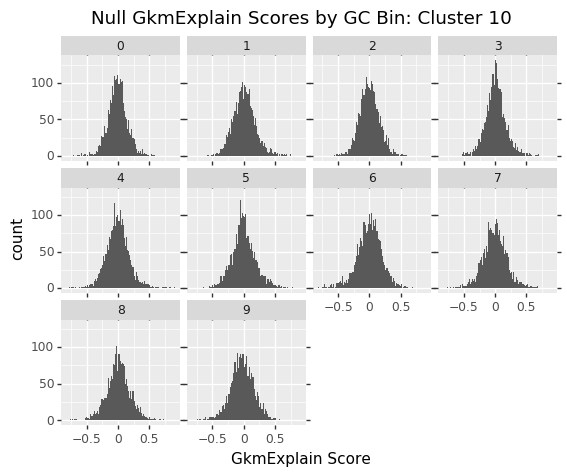

<ggplot: (8733134365437)>

In [13]:
display(ggplot(data=null_scores, mapping=aes(x='null_explain_score'))
        + geom_histogram(bins=100)
        + labs(title='Null GkmExplain Scores by GC Bin: Cluster ' + cluster, x='GkmExplain Score')
        + facet_wrap("gc_bin"))

# Fit Distribution to Null GkmExplain Scores

Fitted t Distribution: 

Mean: 	 -0.0013130614160198838
Stdev: 	 0.1554367610132199

KstestResult(statistic=0.006752046537324974, pvalue=0.2708457130883161)



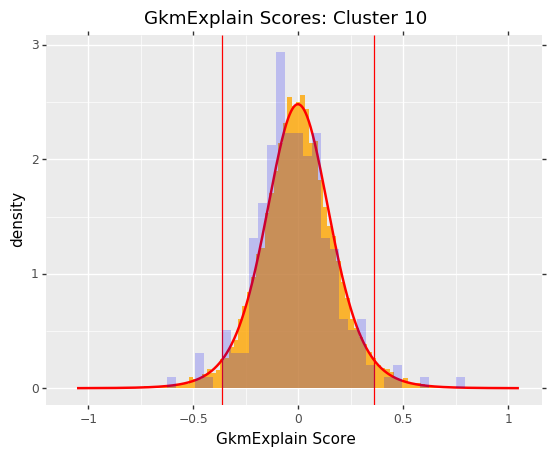

<ggplot: (-9223363303772442315)>

In [14]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
explain_params = distrib.fit(merged_null_explain_scores)
x_explain = np.linspace(distrib.ppf(0.0001, *explain_params[:-2], explain_params[-2], explain_params[-1]),
                        distrib.ppf(0.9999, *explain_params[:-2], explain_params[-2], explain_params[-1]), 10000)
y_explain = distrib.pdf(x_explain, *explain_params[:-2], explain_params[-2], explain_params[-1])
distrib_explain = pd.DataFrame(list(zip(x_explain, y_explain)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', explain_params[-2])
print('Stdev:', '\t', explain_params[-1])
print()
print(kstest(merged_null_explain_scores, distrib_name, args=[*explain_params[:-2], explain_params[-2], explain_params[-1]]))
print()

display(ggplot(data=null_scores, mapping=aes(x='null_explain_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='GkmExplain Scores: Cluster ' + cluster, x='GkmExplain Score')
        + geom_line(data=distrib_explain, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *explain_params[:-2], explain_params[-2], explain_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *explain_params[:-2], explain_params[-2], explain_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='explain_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null ISM Score Distribution by GC Bin

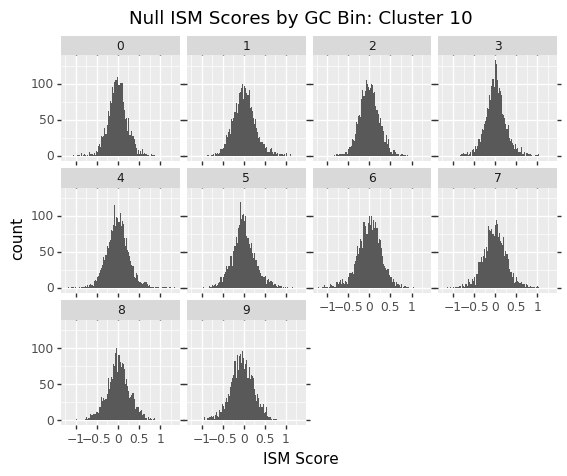

<ggplot: (-9223363303728431188)>

In [15]:
display(ggplot(data=null_scores, mapping=aes(x='null_ism_score'))
        + geom_histogram(bins=100)
        + labs(title='Null ISM Scores by GC Bin: Cluster ' + cluster, x='ISM Score')
        + facet_wrap("gc_bin"))

# Fit Distribution to Null ISM Scores

Fitted t Distribution: 

Mean: 	 -0.0019548832431419494
Stdev: 	 0.23166741162045218

KstestResult(statistic=0.006862686013456409, pvalue=0.2536670407118133)



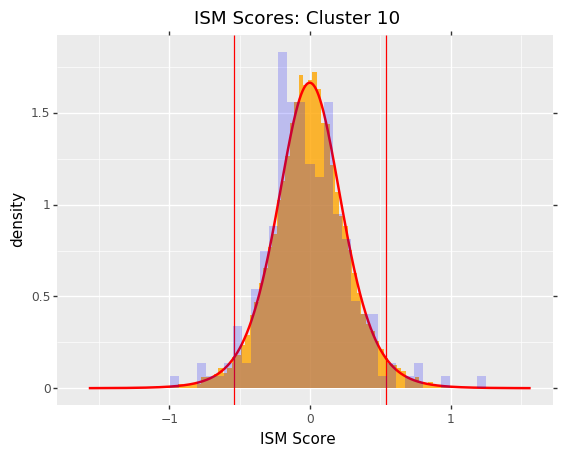

<ggplot: (8733026400453)>

In [16]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
ism_params = distrib.fit(merged_null_ism_scores)
x_ism = np.linspace(distrib.ppf(0.0001, *ism_params[:-2], ism_params[-2], ism_params[-1]),
                        distrib.ppf(0.9999, *ism_params[:-2], ism_params[-2], ism_params[-1]), 10000)
y_ism = distrib.pdf(x_ism, *ism_params[:-2], ism_params[-2], ism_params[-1])
distrib_ism = pd.DataFrame(list(zip(x_ism, y_ism)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', ism_params[-2])
print('Stdev:', '\t', ism_params[-1])
print()
print(kstest(merged_null_ism_scores, distrib_name, args=[*ism_params[:-2], ism_params[-2], ism_params[-1]]))
print()

display(ggplot(data=null_scores, mapping=aes(x='null_ism_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='ISM Scores: Cluster ' + cluster, x='ISM Score')
        + geom_line(data=distrib_ism, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *ism_params[:-2], ism_params[-2], ism_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *ism_params[:-2], ism_params[-2], ism_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='ism_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null deltaSVM Score Distribution by GC Bin

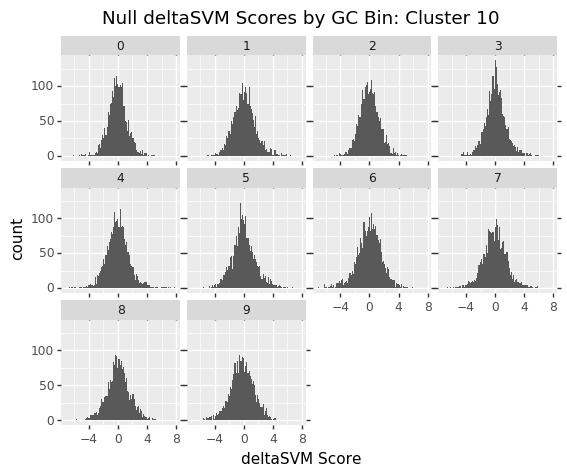

<ggplot: (-9223363303728431153)>

In [17]:
display(ggplot(data=null_scores, mapping=aes(x='null_delta_score'))
        + geom_histogram(bins=100)
        + labs(title='Null deltaSVM Scores by GC Bin: Cluster ' + cluster, x='deltaSVM Score')
        + facet_wrap("gc_bin"))

# Fit Distribution to Null deltaSVM Scores

Fitted t Distribution: 

Mean: 	 -0.01123907893252173
Stdev: 	 1.3391992177803345

KstestResult(statistic=0.006858535645305475, pvalue=0.25429663022069504)



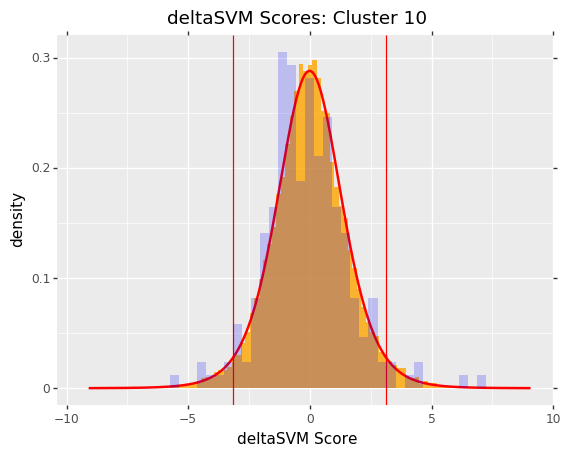

<ggplot: (8733026372342)>

In [18]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
delta_params = distrib.fit(merged_null_delta_scores)
x_delta = np.linspace(distrib.ppf(0.0001, *delta_params[:-2], delta_params[-2], delta_params[-1]),
                        distrib.ppf(0.9999, *delta_params[:-2], delta_params[-2], delta_params[-1]), 10000)
y_delta = distrib.pdf(x_delta, *delta_params[:-2], delta_params[-2], delta_params[-1])
distrib_delta = pd.DataFrame(list(zip(x_delta, y_delta)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', delta_params[-2])
print('Stdev:', '\t', delta_params[-1])
print()
print(kstest(merged_null_delta_scores, distrib_name, args=[*delta_params[:-2], delta_params[-2], delta_params[-1]]))
print()

display(ggplot(data=null_scores, mapping=aes(x='null_delta_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='deltaSVM Scores: Cluster ' + cluster, x='deltaSVM Score')
        + geom_line(data=distrib_delta, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *delta_params[:-2], delta_params[-2], delta_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *delta_params[:-2], delta_params[-2], delta_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='delta_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null Magnitude Score Distribution by GC Bin

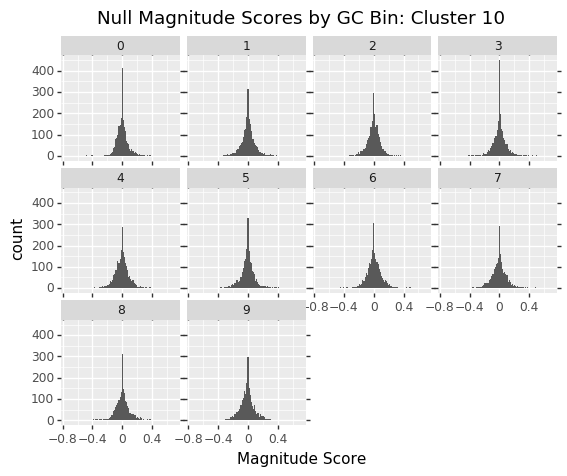

<ggplot: (-9223363303828430311)>

In [19]:
display(ggplot(data=null_scores, mapping=aes(x='null_magnitude_score'))
        + geom_histogram(bins=100)
        + labs(title='Null Magnitude Scores by GC Bin: Cluster ' + cluster, x='Magnitude Score')
        + facet_wrap("gc_bin"))

# Plot All Null Magnitude Scores

Fitted t Distribution: 

Mean: 	 -0.0020512173916139853
Stdev: 	 0.06113221273273289

KstestResult(statistic=0.03550356452585329, pvalue=2.106765627365208e-24)



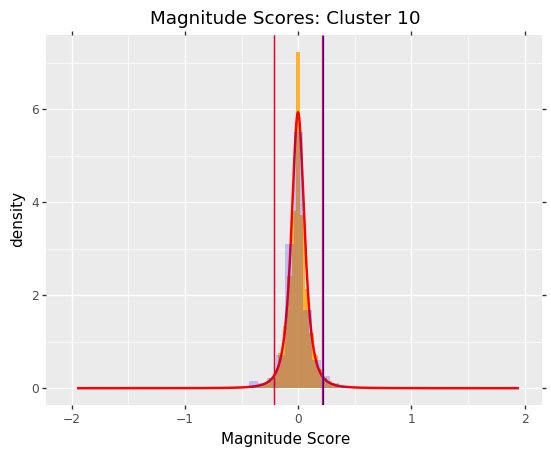

<ggplot: (-9223363303841661019)>

In [20]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
magnitude_params = distrib.fit(null_confidence_dict['null_magnitude_score'])
x_magnitude = np.linspace(distrib.ppf(0.0001, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1]),
                        distrib.ppf(0.9999, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1]), 10000)
y_magnitude = distrib.pdf(x_magnitude, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1])
distrib_magnitude = pd.DataFrame(list(zip(x_magnitude, y_magnitude)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', magnitude_params[-2])
print('Stdev:', '\t', magnitude_params[-1])
print()
print(kstest(null_confidence_dict['null_magnitude_score'], distrib_name, args=[*magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1]]))
print()

null_magnitude_quantiles = list(null_scores['null_magnitude_score'].quantile([0.025, 0.975]))
display(ggplot(data=null_scores, mapping=aes(x='null_magnitude_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='Magnitude Scores: Cluster ' + cluster, x='Magnitude Score')
        + geom_line(data=distrib_magnitude, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=null_magnitude_quantiles[0]), color='blue')
        + geom_vline(mapping=aes(xintercept=null_magnitude_quantiles[1]), color='blue')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='magnitude_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null Prominence Score Distribution by GC Bin

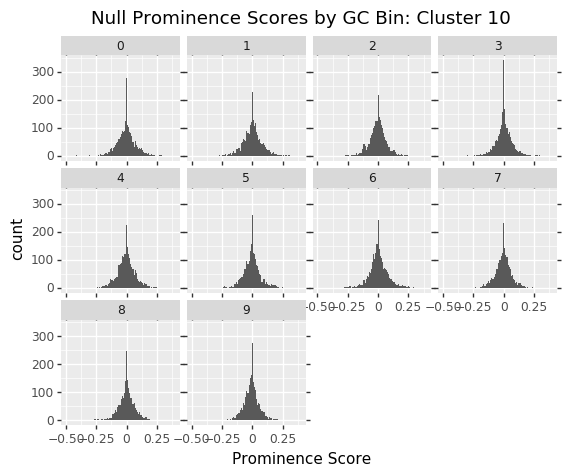

<ggplot: (8733013191509)>

In [21]:
display(ggplot(data=null_scores, mapping=aes(x='null_prominence_score'))
        + geom_histogram(bins=100)
        + labs(title='Null Prominence Scores by GC Bin: Cluster ' + cluster, x='Prominence Score')
        + facet_wrap("gc_bin"))

# Plot All Null Prominence Scores

Fitted t Distribution: 

Mean: 	 -0.0015165880922414156
Stdev: 	 0.05181153237227285

KstestResult(statistic=0.02969561455150599, pvalue=3.363427785295089e-17)



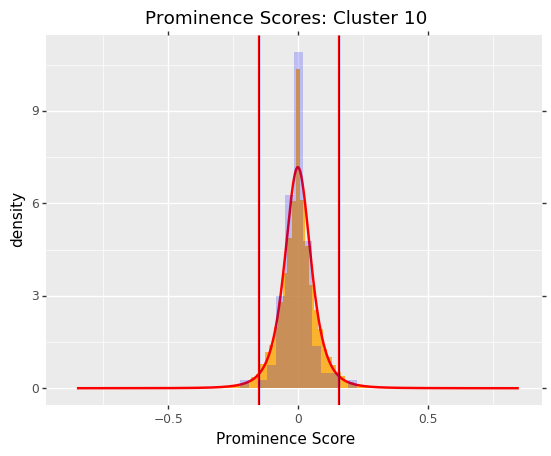

<ggplot: (-9223363303828602322)>

In [22]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
prominence_params = distrib.fit(null_confidence_dict['null_prominence_score'])
x_prominence = np.linspace(distrib.ppf(0.0001, *prominence_params[:-2], prominence_params[-2], prominence_params[-1]),
                        distrib.ppf(0.9999, *prominence_params[:-2], prominence_params[-2], prominence_params[-1]), 10000)
y_prominence = distrib.pdf(x_prominence, *prominence_params[:-2], prominence_params[-2], prominence_params[-1])
distrib_prominence = pd.DataFrame(list(zip(x_prominence, y_prominence)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', prominence_params[-2])
print('Stdev:', '\t', prominence_params[-1])
print()
print(kstest(null_confidence_dict['null_prominence_score'], distrib_name, args=[*prominence_params[:-2], prominence_params[-2], prominence_params[-1]]))
print()
null_prominence_quantiles = list(null_scores['null_prominence_score'].quantile([0.025, 0.975]))

display(ggplot(data=null_scores, mapping=aes(x='null_prominence_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='Prominence Scores: Cluster ' + cluster, x='Prominence Score')
        + geom_line(data=distrib_prominence, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=null_prominence_quantiles[0]), color='blue')
        + geom_vline(mapping=aes(xintercept=null_prominence_quantiles[1]), color='blue')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *prominence_params[:-2], prominence_params[-2], prominence_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *prominence_params[:-2], prominence_params[-2], prominence_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='prominence_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null Importance Scores

Fitted t Distribution: 

Mean: 	 0.0026142470721196216
Stdev: 	 0.0076835623794682655

KstestResult(statistic=0.016960930630883775, pvalue=2.6995489345293077e-250)



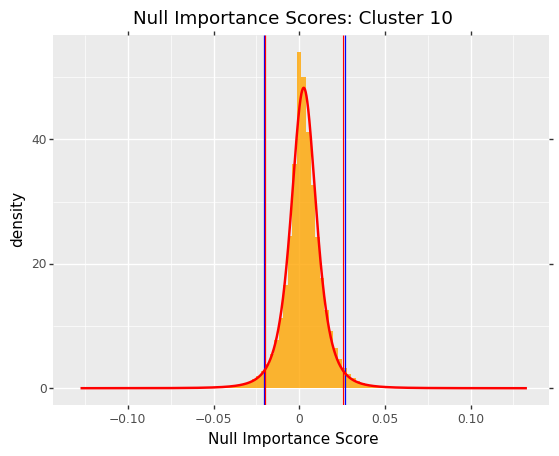

<ggplot: (-9223363303841680857)>

In [23]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
sampled_null_importance_scores = random.sample(null_importance_scores, 1000000)
null_importance_df = pd.DataFrame(sampled_null_importance_scores, columns=['null_importance_score'])
importance_params = distrib.fit(sampled_null_importance_scores)
x_importance = np.linspace(distrib.ppf(0.0001, *importance_params[:-2], importance_params[-2], importance_params[-1]),
                           distrib.ppf(0.9999, *importance_params[:-2], importance_params[-2], importance_params[-1]), 10000)
y_importance = distrib.pdf(x_importance, *importance_params[:-2], importance_params[-2], importance_params[-1])
distrib_importance = pd.DataFrame(list(zip(x_importance, y_importance)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', importance_params[-2])
print('Stdev:', '\t', importance_params[-1])
print()
print(stats.kstest(sampled_null_importance_scores, distrib_name, args=[*importance_params[:-2], importance_params[-2], importance_params[-1]]))
print()
null_importance_quantiles = list(null_importance_df['null_importance_score'].quantile([0.025, 0.975]))

display(ggplot(data=null_importance_df, mapping=aes(x='null_importance_score'))       
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='Null Importance Scores: Cluster ' + cluster, x='Null Importance Score')
        + geom_vline(mapping=aes(xintercept=null_importance_quantiles[0]), color='blue')
        + geom_vline(mapping=aes(xintercept=null_importance_quantiles[1]), color='blue')
        + geom_line(data=distrib_importance, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *importance_params[:-2], importance_params[-2], importance_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *importance_params[:-2], importance_params[-2], importance_params[-1])), color='red'))

# Get P-values for SNP Scores <a name='calculate_pvals' />

In [24]:
snp_scores['explain_pval'] = [(2 * min(distrib.cdf(x, *explain_params[:-2], explain_params[-2], explain_params[-1]),
                                      1 - distrib.cdf(x, *explain_params[:-2], explain_params[-2], explain_params[-1]))) \
                              for x in snp_scores['explain_score']]
snp_scores['ism_pval'] = [(2 * min(distrib.cdf(x, *ism_params[:-2], ism_params[-2], ism_params[-1]),
                                  1 - distrib.cdf(x, *ism_params[:-2], ism_params[-2], ism_params[-1]))) \
                              for x in snp_scores['ism_score']]
snp_scores['delta_pval'] = [(2 * min(distrib.cdf(x, *delta_params[:-2], delta_params[-2], delta_params[-1]),
                                  1 - distrib.cdf(x, *delta_params[:-2], delta_params[-2], delta_params[-1]))) \
                              for x in snp_scores['delta_score']]
snp_scores['magnitude_pval'] = [(2 * min((percentileofscore(list(null_scores['null_magnitude_score']), x) / 100),
                                         (1 - (percentileofscore(list(null_scores['null_magnitude_score']), x) / 100)))) \
                                for x in snp_scores['magnitude_score']]
snp_scores['prominence_pval'] = [(2 * min((percentileofscore(list(null_scores['null_prominence_score']), x) / 100),
                                          (1 - (percentileofscore(list(null_scores['null_prominence_score']), x) / 100)))) \
                                 for x in snp_scores['prominence_score']]

confidence_values = []

for index, row in snp_scores.iterrows():
    confidence = -1
    if row['explain_pval'] < 0.05 and row['ism_pval'] < 0.05 and row['delta_pval'] < 0.5:
        confidence += 1
        if row['prominence_pval'] < 0.05:
            confidence += 2
        elif row['magnitude_pval'] < 0.05 or row['prominence_pval'] < 0.10:
            confidence += 1
    confidence_values.append(confidence)

snp_scores['confidence'] = confidence_values
snp_scores.to_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_snp_scores/Cluster'
                       + cluster + '.' + celltype + '.updated.snp_scores.tsv', sep='\t', index=False)

sig_snps = snp_scores.loc[snp_scores['confidence'] >= 0].copy()
sig_snps = sig_snps.loc[sig_snps['effect'] != 'NAN']
sig_snps = sig_snps.loc[sig_snps['noneffect'] != 'NAN']
unique_sig_snps = sig_snps.sort_values(by=['rsid','prominence_pval'])
unique_sig_snps.drop_duplicates(subset=['rsid'], inplace=True)
unique_sig_snps.sort_values(by=['prominence_pval', 'magnitude_pval', 'explain_pval'], inplace=True)
unique_sig_snps.sort_values(by=['confidence'], ascending=False, inplace=True)

print('Unique Significant SNPs:')
print()
display(unique_sig_snps)
display(unique_sig_snps.shape)
print()
print('SNPs with Significant Scores:', '\t', '\t', '\t', len(unique_sig_snps))
print('Significant SNPs with Low Confidence:', '\t', '\t', len(unique_sig_snps.loc[unique_sig_snps['confidence'] == 0]))
print('Significant SNPs with Moderate Confidence:', '\t', len(unique_sig_snps.loc[unique_sig_snps['confidence'] == 1]))
print('Significant SNPs with High Confidence:', '\t', '\t', len(unique_sig_snps.loc[unique_sig_snps['confidence'] == 2]))
print()
print('Total SNPs Tested: ', '\t', '\t', '\t', '\t', len(snp_scores))
print('Unique SNPs Tested: ', '\t', '\t', '\t', '\t', len(snp_scores.sort_values(by='rsid').drop_duplicates(subset='rsid')))

Unique Significant SNPs:



,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,gc,explain_score,ism_score,delta_score,magnitude_score,prominence_score,gc_bin,gwas,gwas_pval,coloc,active_motif,inactive_motif,diff_motif,active_allele,explain_pval,ism_pval,delta_pval,magnitude_pval,prominence_pval,confidence
79,chr17,45947293,45947294,rs62062786,G,C,G,"A,C",G,"A,C",+,54,0.482,0.765461,1.247520,7.120581,0.257536,0.204292,1,23andme_PD_hg38,4.530000e-22,True,CCAGCTGCCA,CCACCTGCCA,CCA(G/C)CTGCCA,effect,0.001423,0.000841,0.000910,0.032511,0.019087,2
101,chr19,18438073,18438074,rs2303696,T,C,T,C,C,T,-,69,0.714,-0.483715,-0.775852,-4.373297,-0.380203,-0.200041,9,Alzheimers_Kunkle_2019,1.890000e-05,True,GTCCCCGCCCC,GTCCCTGCCCC,GTCCC(C/T)GCCCC,noneffect,0.015999,0.011420,0.012866,0.008037,0.020000,2
90,chr17,46771150,46771151,rs199523,C,A,C,A,A,C,-,54,0.693,0.466200,0.739214,4.267477,0.326974,0.152800,8,23andme_PD_hg38,9.490000e-14,True,CGCCACCTACAG,AGCCACCTACAG,(C/A)GCCACCTACAG,effect,0.018395,0.013973,0.014067,0.015434,0.055068,1
163,chr3,49007333,49007334,rs6781790,T,C,C,T,T,C,+,92,0.658,-0.425645,-0.670523,-3.873297,-0.365091,-0.129322,7,Chang_23andMe_Parkinsons,2.349340e-03,False,GAGGGCGCTGTT,GAGGGTGCTGTT,GAGGG(C/T)GCTGTT,noneffect,0.027721,0.022051,0.022127,0.009132,0.083653,1
136,chr2,95057163,95057164,rs872580,C,A,C,A,A,C,-,85,0.565,-0.452384,-0.701932,-4.087482,-0.146041,-0.124340,4,Nalls_23andMe,4.037170e-02,False,ATGGCACTCG,ATGGCCCTCG,ATGGC(A/C)CTCG,noneffect,0.021484,0.018076,0.017506,0.123470,0.093242,1
139,chr2,95323523,95323524,rs3755519,T,A,A,"C,G,T",T,"A,C,G",+,85,0.639,-0.599483,-0.942781,-5.444462,-0.106706,-0.055194,7,Nalls_23andMe,7.682450e-03,False,CAGGAGTGCT,CAGGTGTGCT,CAGG(A/T)GTGCT,noneffect,0.005633,0.004261,0.004287,0.215068,0.370411,0
72,chr17,45940574,45940575,rs62061732,T,G,G,T,G,T,-,54,0.458,0.362503,0.566396,3.259889,0.036364,0.044554,1,23andme_PD_hg38,3.040000e-22,True,CCAGTTAAGG,CCAGGTAAGG,CCAG(T/G)TAAGG,effect,0.049757,0.042041,0.042738,0.552511,0.424566,0
214,chr8,22604860,22604861,rs3735901,T,C,T,C,T,C,-,125,0.683,0.615094,0.965579,6.293620,0.034264,0.017416,8,Chang_23andMe_Parkinsons,5.081120e-02,False,CCCCTGCCGC,CCCCCGCCGC,CCCC(T/C)GCCGC,effect,0.004813,0.003665,0.001879,0.566758,0.688037,0
120,chr19,44915228,44915229,rs12691088,A,G,G,"A,C",G,"A,C",+,71,0.583,0.408260,0.683364,3.935701,0.000000,0.000000,5,Alzheimers_Kunkle_2019,2.690000e-238,True,GGGTAGGGGG,GGGTGGGGGG,GGGT(A/G)GGGGG,effect,0.031944,0.019828,0.020159,0.980365,0.979543,0


(9, 32)


SNPs with Significant Scores: 	 	 	 9
Significant SNPs with Low Confidence: 	 	 4
Significant SNPs with Moderate Confidence: 	 3
Significant SNPs with High Confidence: 	 	 2

Total SNPs Tested:  	 	 	 	 230
Unique SNPs Tested:  	 	 	 	 209


# Visualize High Confidence SNPs <a name='visualize_high_conf' />


Index: 79

RSID: rs62062786 	 	 || 	 chr17 : 45947293 - 45947294 	 || 	 Locus: 54

GWAS: 23andme_PD_hg38 	 || 	 P-Value: 4.5300E-22 	 	 || 	 Coloc: True

Prominence P-Value: 1.9087E-02 	 || 	 Magnitude P-Value: 3.2511E-02 	 || 	 Confidence: 2

GkmExplain P-Value: 1.4227E-03 	 || 	 ISM P-Value: 8.4137E-04 	 || 	 deltaSVM P-Value: 9.0960E-04

----------------------------------------------------------------------------------------------------

Effect Allele: G 	 	 || 	 Active Motif: CCAGCTGCCA



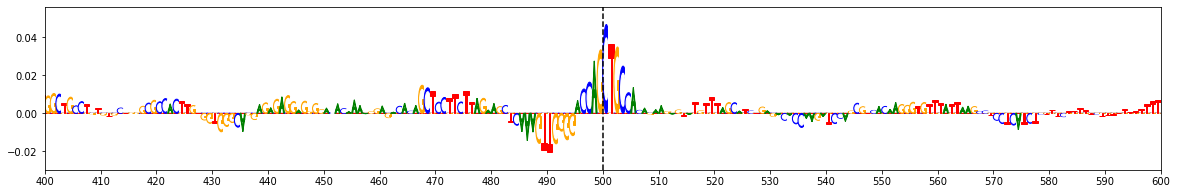


Non-Effect Allele: C 	 	 || 	 Inactive Motif: CCACCTGCCA



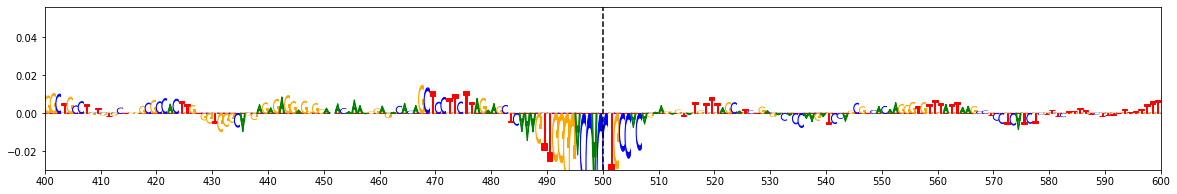


Difference Motif: CCA(G/C)CTGCCA



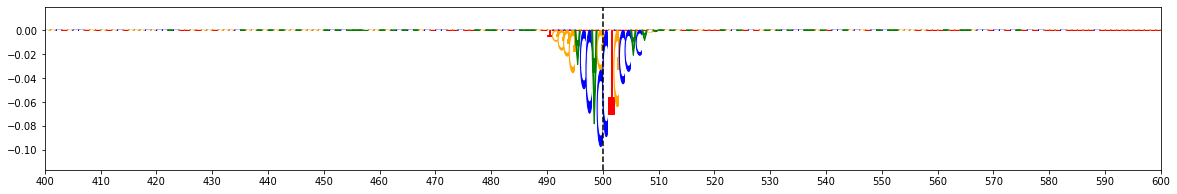


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 101

RSID: rs2303696 	 	 || 	 chr19 : 18438073 - 18438074 	 || 	 Locus: 69

GWAS: Alzheimers_Kunkle_2019 	 || 	 P-Value: 1.8900E-05 	 	 || 	 Coloc: True

Prominence P-Value: 2.0000E-02 	 || 	 Magnitude P-Value: 8.0365E-03 	 || 	 Confidence: 2

GkmExplain P-Value: 1.5999E-02 	 || 	 ISM P-Value: 1.1420E-02 	 || 	 deltaSVM P-Value: 1.2866E-02

----------------------------------------------------------------------------------------------------

Non-Effect Allele: C 	 	 || 	 Active Motif: GTCCCCGCCCC



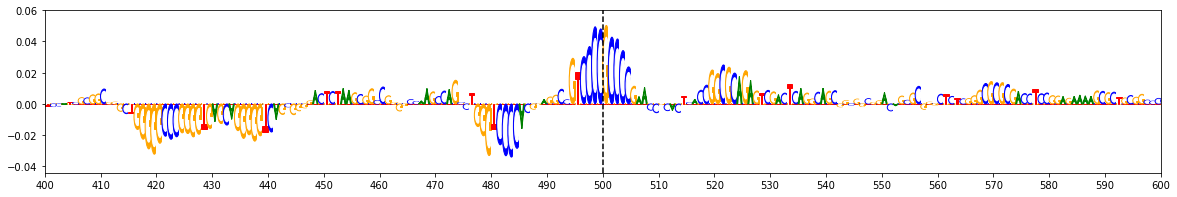


Effect Allele: T 	 	 || 	 Inactive Motif: GTCCCTGCCCC



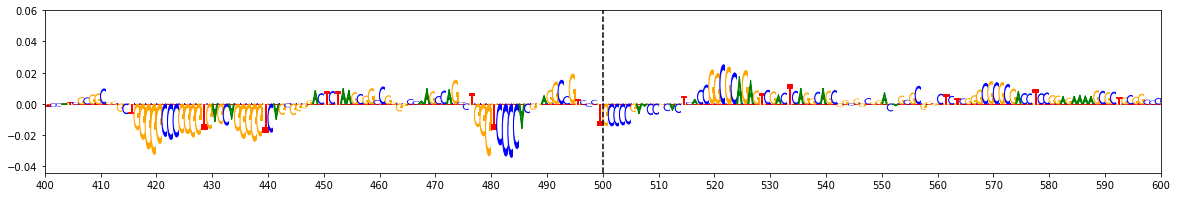


Difference Motif: GTCCC(C/T)GCCCC



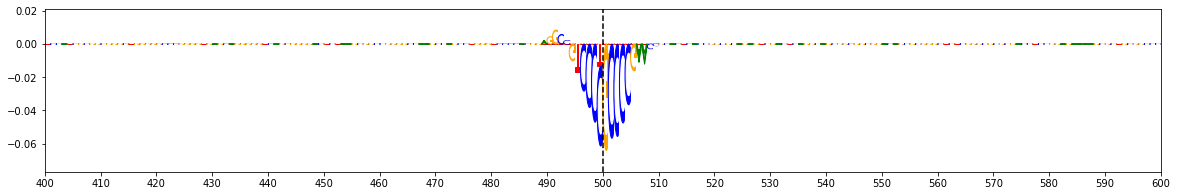


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



In [25]:
for index,row in unique_sig_snps.loc[unique_sig_snps['confidence'] == 2].iterrows():
    print()
    print('Index:', index)
    print()
    print('RSID:', row['rsid'],
          '\t', '\t', '||', '\t',
          row['chr'], ':', row['start'], '-', row['end'],
          '\t', '||', '\t',
          'Locus:', row['locus_num'])
    print()
    print('GWAS:', row['gwas'],
          '\t', '||', '\t',
          'P-Value:', '%.4E' % Decimal(row['gwas_pval']),
          '\t', '\t', '||', '\t',
          'Coloc:', row['coloc'])
    print()
    print('Prominence P-Value:', '%.4E' % Decimal(row['prominence_pval']),
          '\t', '||', '\t',
          'Magnitude P-Value:', '%.4E' % Decimal(row['magnitude_pval']),
          '\t', '||', '\t',
          'Confidence:', row['confidence'])
    print()
    print('GkmExplain P-Value:', '%.4E' % Decimal(row['explain_pval']),
          '\t', '||', '\t',
          'ISM P-Value:', '%.4E' % Decimal(row['ism_pval']),
          '\t', '||', '\t',
          'deltaSVM P-Value:', '%.4E' % Decimal(row['delta_pval']))    
    print()
    print('-'*100)
    print()
    
    #--------------------------------------#
    
    if row['active_allele'] == 'effect':
        if row['effect'] != 'NAN':
            print('Effect Allele:', row['effect'],
                  '\t', '\t', '||', '\t',
                  'Active Motif:', row['active_motif'])
        else:
            print('Minor Allele:', row['minor'],
                  '\t', '\t', '||', '\t',
                  'Active Motif:', row['active_motif'])
        print()
        ylim = plot_weights(merged_real_effect_scores[index],
                            subticks_frequency=10, xlim=(400,600))
        print()
    else:
        if row['noneffect'] != 'NAN':
            print('Non-Effect Allele:', row['noneffect'],
                  '\t', '\t', '||', '\t',
                  'Active Motif:', row['active_motif'])
        else:
            print('Major Allele:', row['major'],
                  '\t', '\t', '||', '\t',
                  'Active Motif:', row['active_motif'])
        print()
        ylim = plot_weights(merged_real_noneffect_scores[index],
                            subticks_frequency=10, xlim=(400,600))
        print()
        
    #--------------------------------------#
        
    if row['active_allele'] != 'effect':
        if row['effect'] != 'NAN':
            print('Effect Allele:', row['effect'],
                  '\t', '\t', '||', '\t',
                  'Inactive Motif:', row['inactive_motif'])
        else:
            print('Minor Allele:', row['minor'],
                  '\t', '\t', '||', '\t',
                  'Inactive Motif:', row['inactive_motif'])
        print()
        a = plot_weights(merged_real_effect_scores[index],
                         subticks_frequency=10, ylim=ylim, xlim=(400,600))
        print()
    else:
        if row['noneffect'] != 'NAN':
            print('Non-Effect Allele:', row['noneffect'],
                  '\t', '\t', '||', '\t',
                  'Inactive Motif:', row['inactive_motif'])
        else:
            print('Major Allele:', row['major'],
                  '\t', '\t', '||', '\t',
                  'Inactive Motif:', row['inactive_motif'])
        print()
        a = plot_weights(merged_real_noneffect_scores[index],
                         subticks_frequency=10, ylim=ylim, xlim=(400,600))
        print()
    
    #--------------------------------------#
    
    print('Difference Motif:', row['diff_motif'])
    print()
    if row['active_allele'] == 'effect':
        a = plot_weights(merged_real_noneffect_scores[index] - merged_real_effect_scores[index],
                         subticks_frequency=10, xlim=(400,600))
    else:
        a = plot_weights(merged_real_effect_scores[index] - merged_real_noneffect_scores[index],
                         subticks_frequency=10, xlim=(400,600))
    print()
    print('-'*100)
    print('-'*100)
    print()

## Generate Signal Tracks

In [26]:
fc_tracks = []
pval_tracks = []

for index, row in unique_sig_snps.iterrows():
    chrom = row['chr']
    start = row['start'] - 2500
    end = row['end'] + 2500
    rsid = row['rsid']
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/fc_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_snp_fc_signal_tracks/{rsid}.fc.png
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/pval_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_snp_pval_signal_tracks/{rsid}.pval.png
    fc_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/updated_snp_fc_signal_tracks/'+rsid+'.fc.png')
    pval_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/updated_snp_pval_signal_tracks/'+rsid+'.pval.png')
        
unique_sig_snps['fc_track'] = fc_tracks
unique_sig_snps['pval_track'] = pval_tracks

INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.03140068054199219
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 

# Final Significant SNPs Table <a name='prep_final_table' />

In [27]:
final_sig_snps = unique_sig_snps[['chr', 'start', 'end', 'rsid',
                                  'effect', 'noneffect', 'major', 'minor', 'direction',
                                  'locus_num', 'gwas', 'gwas_pval', 'coloc',
                                  'explain_pval', 'ism_pval', 'delta_pval',
                                  'magnitude_pval', 'prominence_pval', 'confidence',
                                  'active_motif', 'diff_motif', 'active_allele',
                                  'fc_track', 'pval_track']]

final_sig_snps.to_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_sig_snps/Cluster'
                       + cluster + '.' + celltype + '.updated.unique.sig_snps.tsv', sep='\t', index=False)
print('Final Significant SNPs Table:')
print()
display(final_sig_snps)

Final Significant SNPs Table:



,chr,start,end,rsid,effect,noneffect,major,minor,direction,locus_num,gwas,gwas_pval,coloc,explain_pval,ism_pval,delta_pval,magnitude_pval,prominence_pval,confidence,active_motif,diff_motif,active_allele,fc_track,pval_track
79,chr17,45947293,45947294,rs62062786,G,C,G,"A,C",+,54,23andme_PD_hg38,4.530000e-22,True,0.001423,0.000841,0.000910,0.032511,0.019087,2,CCAGCTGCCA,CCA(G/C)CTGCCA,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
101,chr19,18438073,18438074,rs2303696,T,C,C,T,-,69,Alzheimers_Kunkle_2019,1.890000e-05,True,0.015999,0.011420,0.012866,0.008037,0.020000,2,GTCCCCGCCCC,GTCCC(C/T)GCCCC,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
90,chr17,46771150,46771151,rs199523,C,A,A,C,-,54,23andme_PD_hg38,9.490000e-14,True,0.018395,0.013973,0.014067,0.015434,0.055068,1,CGCCACCTACAG,(C/A)GCCACCTACAG,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
163,chr3,49007333,49007334,rs6781790,T,C,T,C,+,92,Chang_23andMe_Parkinsons,2.349340e-03,False,0.027721,0.022051,0.022127,0.009132,0.083653,1,GAGGGCGCTGTT,GAGGG(C/T)GCTGTT,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
136,chr2,95057163,95057164,rs872580,C,A,A,C,-,85,Nalls_23andMe,4.037170e-02,False,0.021484,0.018076,0.017506,0.123470,0.093242,1,ATGGCACTCG,ATGGC(A/C)CTCG,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
139,chr2,95323523,95323524,rs3755519,T,A,T,"A,C,G",+,85,Nalls_23andMe,7.682450e-03,False,0.005633,0.004261,0.004287,0.215068,0.370411,0,CAGGAGTGCT,CAGG(A/T)GTGCT,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
72,chr17,45940574,45940575,rs62061732,T,G,G,T,-,54,23andme_PD_hg38,3.040000e-22,True,0.049757,0.042041,0.042738,0.552511,0.424566,0,CCAGTTAAGG,CCAG(T/G)TAAGG,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
214,chr8,22604860,22604861,rs3735901,T,C,T,C,-,125,Chang_23andMe_Parkinsons,5.081120e-02,False,0.004813,0.003665,0.001879,0.566758,0.688037,0,CCCCTGCCGC,CCCC(T/C)GCCGC,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
120,chr19,44915228,44915229,rs12691088,A,G,G,"A,C",+,71,Alzheimers_Kunkle_2019,2.690000e-238,True,0.031944,0.019828,0.020159,0.980365,0.979543,0,GGGTAGGGGG,GGGT(A/G)GGGGG,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
